# Step #1 Load the Data

In [11]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
# symbols = get_nasdaq_symbols()

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'Apple'
symbol = 'AAPL'
# df = webreader.DataReader(
#     symbol, start=start_date, end=end_date, data_source="yahoo"
# )

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# # Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.5.0
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.444381,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.544687,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.556002,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.451721,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.439794,477131200
...,...,...,...,...,...,...
2022-04-26,162.250000,162.339996,156.720001,156.800003,156.800003,95623200
2022-04-27,155.910004,159.789993,155.380005,156.570007,156.570007,88063200
2022-04-28,159.250000,164.520004,158.929993,163.639999,163.639999,130216800


# Step #2 Exploring the Data

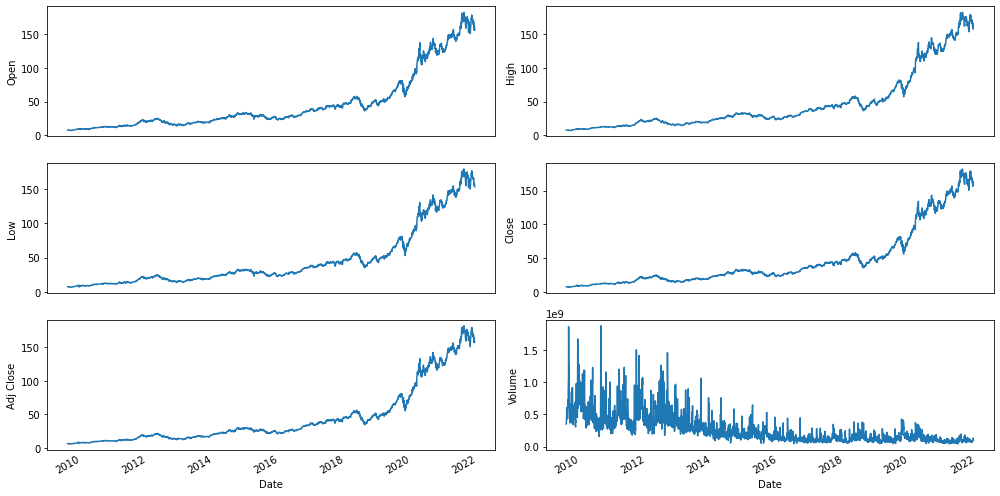

In [12]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [13]:
# Indexing Batches
df_train = df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = df_train.index

# We reset the index, so we can convert the date-index to a number-index
df_train = df_train.reset_index(drop=True).copy()
df_train.tail(5)

,Open,High,Low,Close,Adj Close,Volume
3100,162.250000,162.339996,156.720001,156.800003,156.800003,95623200
3101,155.910004,159.789993,155.380005,156.570007,156.570007,88063200
3102,159.250000,164.520004,158.929993,163.639999,163.639999,130216800
3103,161.839996,166.199997,157.250000,157.649994,157.649994,131587100
3104,156.710007,158.229996,153.270004,157.960007,157.960007,122947800


In [14]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['Close']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled
    
np_filter_unscaled, np_c_unscaled = prepare_data(df_train)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume']
(3105, 5)


(2424, 50, 5) (2424, 10)
(611, 50, 5) (611, 10)


<function matplotlib.pyplot.show(close=None, block=None)>

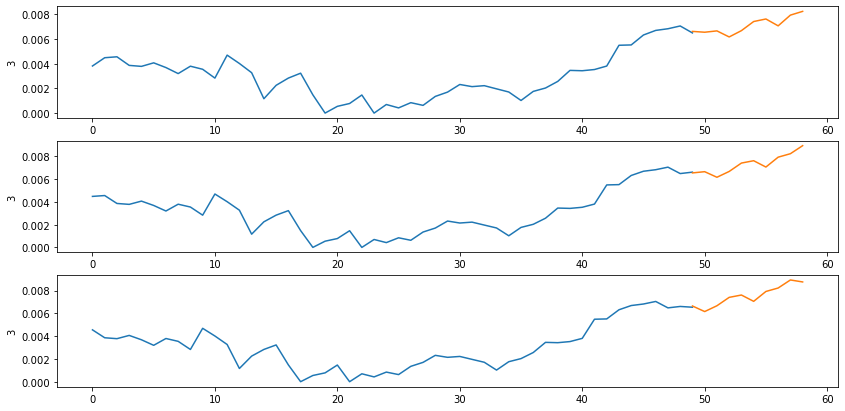

In [15]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 10 #

# Prediction Index
index_Close = df_train.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[0:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(14, 7))
for i in range(nrows):
    sns.lineplot(y = pd.DataFrame(x_train[i])[index_Close], x = range(input_sequence_length), ax = ax[i])
    sns.lineplot(y = y_train[i], x = range(input_sequence_length -1, input_sequence_length + output_sequence_length - 1), ax = ax[i])
plt.show

# Step #4 Model Training

In [16]:
# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [17]:
# Training the model
epochs = 5
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/5
152/152 [==============================] - 15s 75ms/step - loss: 0.0024 - val_loss: 0.0296
Epoch 2/5
152/152 [==============================] - 10s 67ms/step - loss: 3.3670e-04 - val_loss: 0.0065
Epoch 3/5
152/152 [==============================] - 10s 65ms/step - loss: 1.0044e-04 - val_loss: 0.0016
Epoch 4/5
152/152 [==============================] - 10s 67ms/step - loss: 7.8446e-05 - val_loss: 0.0030
Epoch 5/5
152/152 [==============================] - 10s 66ms/step - loss: 7.2194e-05 - val_loss: 0.0015


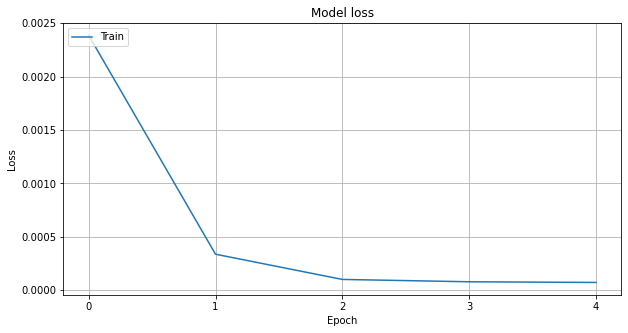

In [18]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [19]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 5.23
Mean Absolute Percentage Error (MAPE): 4.41 %
Median Absolute Percentage Error (MDAPE): 3.65 %


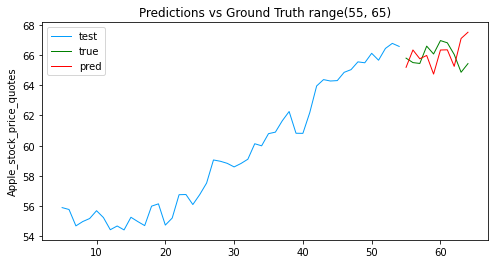

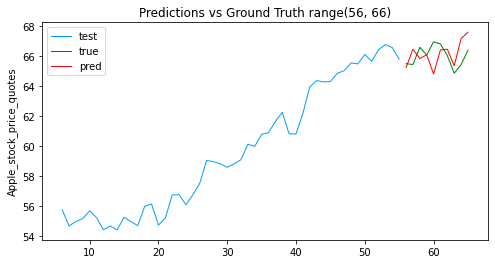

In [20]:
def plot_multi_test_forecast(i, s, x_test, y_test_unscaled, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i, i + test_max_index)
    pred_index = range(i + test_max_index, i + test_max_index + pred_max_index)
    
    # package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true
    data = pd.DataFrame(list(zip(y_pred_unscaled[s], y_test_unscaled[i])), columns=['pred', 'true']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='true', x=pred_index, color="g", linewidth=1.0, label='true')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')

x_test_unscaled = scaler_pred.inverse_transform(np.array(pd.DataFrame(x_test[0])[index_Close]).reshape(-1, 1)) 
df_test = pd.DataFrame(x_test_unscaled)
    
for i in range(5, 7): #i is the starting point for the batch in the time-series
    #data = pd.DataFrame(list(zip(y_pred[i], y_test_unscaled[i])), columns=['pred', 'true'], index=range(55,65))
    plot_multi_test_forecast(i, i, x_test, y_test_unscaled, y_pred)
    

# Step #6 Create a new Forecast

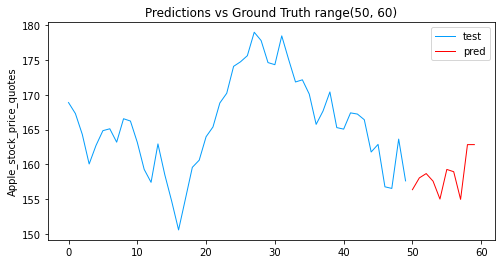

In [21]:
def plot_new_multi_forecast(i_test, i_pred, x_test, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i_test])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i_test, i_test + test_max_index)
    pred_index = range(i_test + test_max_index, i_test + test_max_index + pred_max_index)
    
    data = pd.DataFrame(list(zip(y_pred_unscaled[i_pred])), columns=['pred']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')
    
# get the highest index from the x_test dataset
index_max = x_test.shape[0]
x_test_new = np_scaled[-51:-1,:].reshape(1,50,5)

# undo the scaling of the predictions
y_pred_scaled = model.predict(x_test_new)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

# plot the predictions
plot_new_multi_forecast(0, 0, x_test_new, y_pred)